In [1]:
# Main libraries required
import qiskit as qk
import numpy as np
from scipy.optimize import minimize
from itertools import product, combinations, permutations

# Plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import seaborn as sns

# QAOA implementation using conventional problem encoding
from tsp_qaoa_orig import TSP_QAOA_Orig

In [2]:
# Held-Karp
# Keys in table: Use the nodes in the set to reach the point in the second tuple element. 
# Values in table: Order of the optimum tour and the total distance
def tsp_dynamic(adj_matrix, first_node=0, last_node=0):
    n = adj_matrix.shape[0]
    init_minimum = np.sum(adj_matrix)
    table = {}
    for i in range(n):
        table[(frozenset((i,)),i)] = ((i,), adj_matrix[first_node, i])
    nodes = frozenset(range(n)).difference((first_node, last_node))
    for s in range(2, len(nodes)+1):
        for S in combinations(nodes, s):
            set_S = frozenset(S)
            for k in S:
                minimum_distance = init_minimum
                minimum_path = None
                set_Smk = set_S.difference((k,))
                for m in set_Smk:
                    table_entry = table[(set_Smk, m)]
                    distance = table_entry[1] + adj_matrix[m,k]
                    if distance < minimum_distance:
                        minimum_distance = distance
                        minimum_path = table_entry[0]
                table[(set_S, k)] = (minimum_path + (k,), minimum_distance)
    
    minimum_distance = init_minimum
    minimum_path = None
    # Find Minimum
    for i in nodes:
        table_entry = table[(nodes, i)]
        distance = table_entry[1] + adj_matrix[i,last_node]
        if distance < minimum_distance:
            minimum_distance = distance
            minimum_path = table_entry[0] + (last_node,)
    return (minimum_path, minimum_distance)

In [3]:
def compute_path_length(path, adj_matrix):
    length = 0
    for i,j in zip(path[:-1], path[1:]):
        length += adj_matrix[i,j]
    return length

def path_from_string(string):
    n = int(0.5*(3 + (4*len(string) + 1)**0.5))
    edge_in = set(range(1, n))
    edges = set()
    rev_string = string[::-1]
    value = None
    for bit, edge in enumerate(permutations(range(1, n), 2)):
        value = rev_string[bit]
        if value == "1":
            edges.add(edge)
            edge_in.remove(edge[1])
    path = [0, edge_in.pop()]
    while edges:
        for edge in edges:
            if edge[0] == path[-1]:
                path.append(edge[1])
                edges.remove(edge)
                break
    return path + [0]

In [4]:
class TSP_QAOA:
    def __init__(self, n, p):
        assert (n > 2) and (n < 5)
        
        self.qubits = None
        self.cbits = None
        self.circuit = None
        self.matrix_bound = None
        self.params_bound = None
        self.beta = None
        self.gamma = None
        self.matrix = None
        self.p = p
        self.n = n
        self.adj_matrix = None
        self.opt_iterations = 0

    def build_state_preparation(self):
        # TODO: Abstract to an arbitrary number of cities
        # TODO: This should work recursively (somehow)
        if self.n == 3:
            self.circuit.h(0)
            self.circuit.cx(0, 1)
            self.circuit.x(0)
        elif self.n == 4:
            self.circuit.ry(np.arccos(-1/3), 0)
            self.circuit.ch(0, 1)
            self.circuit.ch(1, 2)
            self.circuit.cx(2, 3)
            self.circuit.cx(1, 2)
            self.circuit.cx(0, 1)
            self.circuit.x(0)
            self.circuit.ch(1, 2)
            self.circuit.cx(2, 5)
            self.circuit.cx(1, 2)
            self.circuit.ch(0, 3)
            self.circuit.cx(3, 4)
            self.circuit.cx(0, 3)
        else:
            pass

    def reverse_state_preparation(self):
        # TODO: Abstract to an arbitrary number of cities
        if self.n == 3:
            self.circuit.x(0)
            self.circuit.cx(0, 1)
            self.circuit.h(0)
        elif self.n == 4:
            self.circuit.cx(0, 3)
            self.circuit.cx(3, 4)
            self.circuit.ch(0, 3)
            self.circuit.cx(1, 2)
            self.circuit.cx(2, 5)
            self.circuit.ch(1, 2)
            self.circuit.x(0)
            self.circuit.cx(0, 1)
            self.circuit.cx(1, 2)
            self.circuit.cx(2, 3)
            self.circuit.ch(1, 2)
            self.circuit.ch(0, 1)
            self.circuit.ry(-np.arccos(-1/3), 0)
        else:
            pass

    def build_phase_separator(self, parameter):
        """
        Phase separator for a single iteration, hence only a single parameter is used
        """
        for qubit, edge in enumerate(permutations(range(1, self.n), 2)):
            self.circuit.p(2 * parameter * (self.matrix[edge[0]][edge[1]] - (self.n-3)*(self.matrix[edge[0]][0]/(self.n-2)) - (self.n-3)*(self.matrix[0][edge[1]]/(self.n-2))), qubit)
            self.circuit.x(qubit)
            self.circuit.p(2 * parameter * (self.matrix[edge[0]][0]/(self.n-2) + self.matrix[0][edge[1]]/(self.n-2)), qubit)
            self.circuit.x(qubit)

    def build_mixer(self, parameter):
        """
        Mixer for a single iteration, hence only a single parameter is used
        """
        self.reverse_state_preparation()

        self.circuit.x(self.qubits)

        cp_gate = qk.circuit.library.standard_gates.PhaseGate(parameter).control(len(self.qubits) - 1)
        self.circuit.append(cp_gate, self.qubits)

        self.circuit.x(self.qubits)

        self.build_state_preparation()

    def bind_matrix(self, adj_matrix):
        adj_matrix_norm = adj_matrix/(np.max(adj_matrix)*self.n)
        params_matrix = {self.matrix[i][j]: adj_matrix_norm[i,j] for i, j in product(range(self.n), range(self.n)) if i != j}
        self.matrix_bound = self.circuit.assign_parameters(params_matrix)
        self.adj_matrix = adj_matrix

    def bind_parameters(self, parameters):
        assert (self.matrix_bound is not None), "Matrix parameters need to be bound"
        betas = parameters[:self.p]
        gammas = parameters[self.p:]
        
        params_beta = {qcbeta: pbeta for qcbeta, pbeta in zip(self.beta, betas)}
        params_gamma = {qcgamma: pgamma for qcgamma, pgamma in zip(self.gamma, gammas)}
        
        self.params_bound = self.matrix_bound.assign_parameters({**params_beta, **params_gamma})

    def compute_path_length(self, measurement):
        rev_string = measurement[::-1]
        value = 0
        for bit, edge in enumerate(permutations(range(1, self.n), 2)):
            bit_value = rev_string[bit]
            if bit_value == "0":
                value += self.adj_matrix[edge[0]][0]/(self.n-2)
                value += self.adj_matrix[0][edge[1]]/(self.n-2)
            else:
                value -= (self.n-3)*(self.adj_matrix[edge[0]][0]/(self.n-2))
                value -= (self.n-3)*(self.adj_matrix[0][edge[1]]/(self.n-2))
                value += self.adj_matrix[edge[0]][edge[1]]
        return value

    def compute_expectation(self, counts, shots):
        sum_count = 0
        for string, count in counts.items():
            sum_count += self.compute_path_length(string)*count

        return sum_count/shots 
        
    def build_circuit(self, backend):
        self.beta = [qk.circuit.Parameter("beta{}".format(i)) for i in range(self.p)]
        self.gamma = [qk.circuit.Parameter("gamma{}".format(i)) for i in range(self.p)]
        self.matrix = [[qk.circuit.Parameter("matrix{0}{1}".format(i,j)) for j in range(self.n)] for i in range(self.n)]

        self.qubits = qk.QuantumRegister((self.n-1)*(self.n-2))
        self.cbits = qk.ClassicalRegister((self.n-1)*(self.n-2))
        
        self.circuit = qk.QuantumCircuit(self.qubits, self.cbits)

        self.build_state_preparation()
        
        for i in range(self.p):
            self.build_phase_separator(self.gamma[i])
            self.build_mixer(self.beta[i])

        self.circuit.measure(self.qubits, self.cbits)
        self.circuit = qk.transpile(self.circuit, optimization_level=3, backend=backend)

    def run_circuit(self, parameters, backend, shots):
        self.bind_parameters(parameters)
        counts = backend.run(self.params_bound, seed_simulator=42, shots=shots).result().get_counts()
        return counts

    def solve(self, adj_matrix, shots=1000, backend=None):
        assert (self.n == len(adj_matrix)), "Adjacency matrix does not fit with given number of qubits"
        
        if backend is None:
            backend = qk.Aer.get_backend('qasm_simulator')

        if self.circuit is None:
            self.build_circuit(backend)

        self.bind_matrix(adj_matrix)

        def get_circuit_expectation(parameters):
            counts = self.run_circuit(parameters, backend, shots)
            expectation = self.compute_expectation(counts, shots)
            self.opt_iterations += 1
            return expectation
        
        self.opt_iterations = 0
        res = minimize(get_circuit_expectation, [0.5]*(self.p*2), method='COBYLA')
        optim = res.x

        counts = self.run_circuit(optim, backend, shots)
        best_path = max(counts, key=counts.get)
        # expectations = {path: self.compute_path_length(path) for path, _ in counts.items()}
        path_length = self.compute_path_length(best_path)
        best_path = path_from_string(best_path)
        
        return tuple(best_path[1:]), path_length

In [5]:
tsp_size = 4
p = 1
shots = 1000
backend = qk.Aer.get_backend('qasm_simulator')

In [6]:
# We create a new QAOA solver object for our desired circuit size
tsp_qaoa_solver = TSP_QAOA(tsp_size, p)
# Build the circuit with respect to the given backend
# This only needs to be done once - this circuit is parametrized and
# can be used for any TSP instance of the previously defined size
tsp_qaoa_solver.build_circuit(backend)

In [7]:
tsp_qaoa_solver_orig = TSP_QAOA_Orig(tsp_size, p)
tsp_qaoa_solver_orig.build_circuit(backend)

In [8]:
# Generate a random TSP instance
random_tsp = np.random.randint(low=1, high=20, size=(tsp_size, tsp_size))
random_tsp[np.diag_indices(tsp_size)] = 0
random_tsp

array([[ 0, 18,  4,  8],
       [ 5,  0,  5,  7],
       [13, 11,  0, 10],
       [17,  7,  3,  0]])

In [9]:
# This will return 2 values: The computed path and the length of it
# The first (and last) node are assumed to be 0 (without loss of generality)
tsp_qaoa_solver.solve(random_tsp)

((2, 3, 1, 0), 26.0)

In [10]:
tsp_qaoa_solver_orig.solve(random_tsp)

((2, 3, 1, 0), 26)

In [11]:
# Optimal solution - same output format as for the QAOA solution
tsp_dynamic(random_tsp)

((2, 3, 1, 0), 26)

In [12]:
number_of_samples = 1000
tour_lengthts_reference = []
tour_lengthts_approxiamtion = []
opt_iterations_new = []

for i in range(number_of_samples):
    # Generate random TSP of the same size as above
    random_tsp = np.random.randint(low=1, high=20, size=(tsp_size, tsp_size))
    random_tsp[np.diag_indices(tsp_size)] = 0

    # Compute optimum solution
    solution = tsp_dynamic(random_tsp)
    # Compute QAOA approximation
    approximation = tsp_qaoa_solver.solve(random_tsp)

    # For this comparison we are only interested in the returned tour lengths
    tour_lengthts_reference.append(solution[1])
    tour_lengthts_approxiamtion.append(approximation[1])
    opt_iterations_new.append(tsp_qaoa_solver.opt_iterations)

    print("Progress: {:.2f}%".format(((i+1)/number_of_samples)*100), end="\r")

tour_lengthts_reference = np.array(tour_lengthts_reference)
tour_lengthts_approxiamtion = np.array(tour_lengthts_approxiamtion)

[]

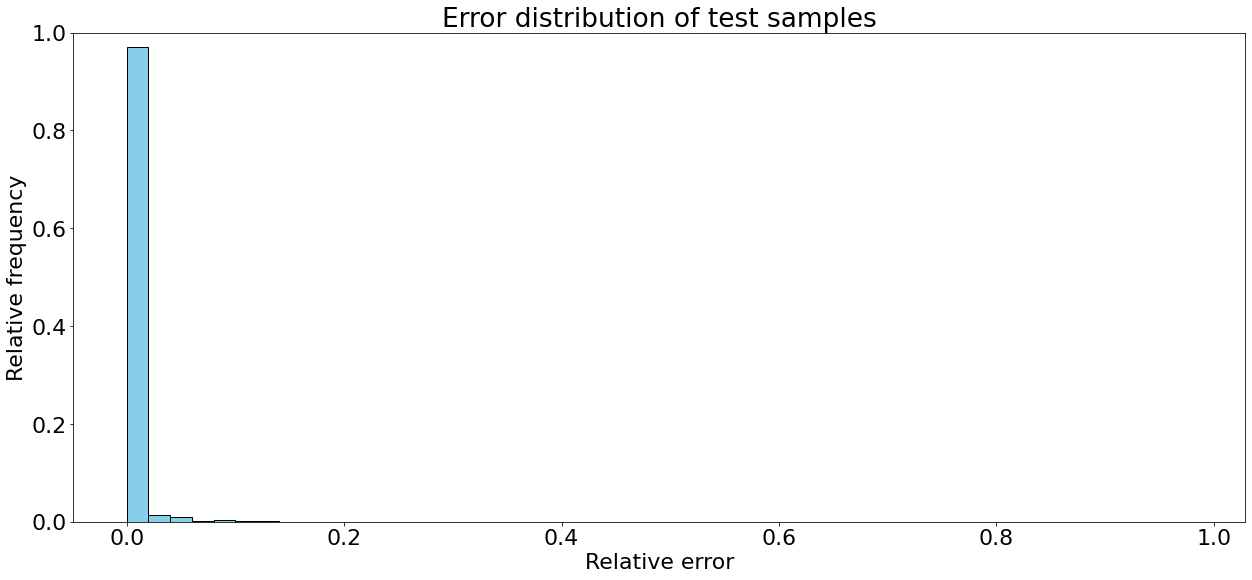

In [13]:
relative_errors = np.abs(tour_lengthts_reference - tour_lengthts_approxiamtion)/tour_lengthts_reference
weights = np.ones_like(relative_errors)/len(relative_errors)

plt.figure(figsize=(21,9))
plt.hist(relative_errors, bins=np.arange(0,1,0.02), weights=weights, edgecolor='black', color='skyblue')
plt.ylim((0, 1))
plt.title("Error distribution of test samples")
plt.xlabel("Relative error")
plt.ylabel("Relative frequency")
plt.plot()

In [14]:
# Fraction of non-optimal QAOA solutions
len(relative_errors[relative_errors>0])/number_of_samples

0.03

In [15]:
# Average relative error of all non-optimal QAOA solutions
np.mean(relative_errors[relative_errors>0])

0.05151151273840233

In [16]:
tour_lengthts_reference = []
tour_lengthts_approxiamtion = []
opt_iterations_orig = []

for i in range(number_of_samples):
    # Generate random TSP of the same size as above
    random_tsp = np.random.randint(low=1, high=20, size=(tsp_size, tsp_size))
    random_tsp[np.diag_indices(tsp_size)] = 0

    # Compute optimum solution
    solution = tsp_dynamic(random_tsp)
    # Compute QAOA approximation
    approximation = tsp_qaoa_solver_orig.solve(random_tsp)

    # For this comparison we are only interested in the returned tour lengths
    tour_lengthts_reference.append(solution[1])
    tour_lengthts_approxiamtion.append(approximation[1])
    opt_iterations_orig.append(tsp_qaoa_solver_orig.opt_iterations)

    print("Progress: {:.2f}%".format(((i+1)/number_of_samples)*100), end="\r")

tour_lengthts_reference = np.array(tour_lengthts_reference)
tour_lengthts_approxiamtion = np.array(tour_lengthts_approxiamtion)

In [17]:
tour_lengthts_reference = np.array(tour_lengthts_reference)
tour_lengthts_approxiamtion = np.array(tour_lengthts_approxiamtion)

[]

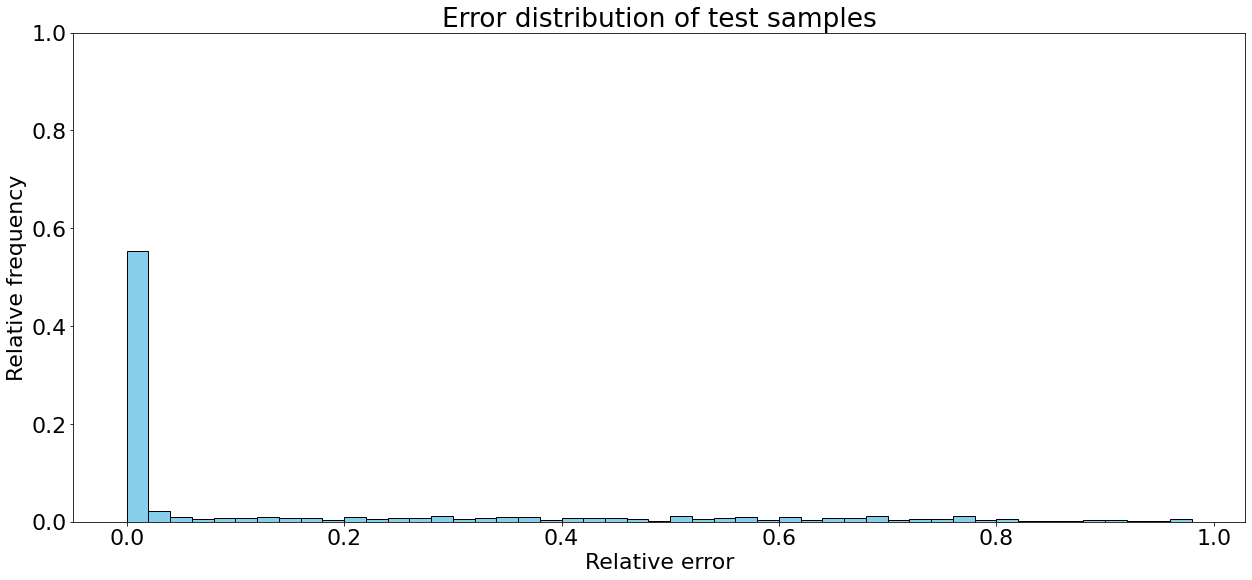

In [18]:
relative_errors = np.abs(tour_lengthts_reference - tour_lengthts_approxiamtion)/tour_lengthts_reference
weights = np.ones_like(relative_errors)/len(relative_errors)

plt.figure(figsize=(21,9))
plt.hist(relative_errors, bins=np.arange(0,1,0.02), weights=weights, edgecolor='black', color='skyblue')
plt.ylim((0, 1))
plt.title("Error distribution of test samples")
plt.xlabel("Relative error")
plt.ylabel("Relative frequency")
plt.plot()

In [19]:
# Fraction of non-optimal QAOA solutions
len(relative_errors[relative_errors>0])/number_of_samples

0.446

In [20]:
# Average relative error of all non-optimal QAOA solutions
np.mean(relative_errors[relative_errors>0])

0.727492335131072